###  你们先试试写写然后就可以看看文章里讲怎么建造portfolio那一块了

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler  
import copy
import yfinance
from collections import defaultdict

Using TensorFlow backend.


In [ ]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

### Preprocessing data

In [135]:
stock_lp = pd.read_csv('C:/Users/Zackt/Documents/SP_500_clean.csv'  , index_col = 0)
days = 100
valid = 150
stock = defaultdict(defaultdict)
stock['calibrate']['lp'] = stock_lp.iloc[0:days, :]
stock['validate']['lp'] = stock_lp.iloc[days:days + valid, :]

pct =  pd.read_csv('C:/Users/Zackt/Documents/SP_500_pct_change.csv'  , index_col = 0)
stock['calibrate']['percentage'] = pct.iloc[:days,:] *100
stock['validate']['percentage'] = pct.iloc[days:days+valid,:] *100

net =  pd.read_csv('C:/Users/Zackt/Documents/SP_500_net_change.csv'  , index_col = 0)
stock['calibrate']['net'] = net.iloc[0:days,:]
stock['validate']['net'] = net.iloc[days:days+valid,:]

spy = defaultdict(defaultdict)
spy_full = pd.read_csv('C:/Users/Zackt/Documents/SP_500_index.csv', index_col=0).astype('float32')

spy_lp = spy_full
spy['calibrate']['lp'] = spy_lp[:days]
spy['validate']['lp'] = spy_lp[days:days+valid]

spy_net = pd.read_csv('C:/Users/Zackt/Documents/SP_500_index_net_change.csv', index_col=0).astype('float32')
spy['calibrate']['net'] = spy_net[:days]
spy['validate']['net'] = spy_net[days:days+valid]

spy_percentage = pd.read_csv('C:/Users/Zackt/Documents/SP_500_index_pct_change.csv', index_col=0).astype('float32')
spy['calibrate']['percentage'] = spy_percentage[:days] * 100
spy['validate']['percentage'] = spy_percentage[days:days+valid] *100

In [22]:
'''

spy['calibrate']['percentage'] 
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('D:/jupyter/Deep-Portfolio-Theory/data/last_price.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['lp'] = stock_lp.iloc[0:104, :]
stock['validate']['lp'] = stock_lp.iloc[104:, :]

stock_net = pd.read_csv('D:/jupyter/Deep-Portfolio-Theory/data/net_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[0:104, :]
stock['validate']['net'] = stock_net.iloc[104:, :]

stock_percentage = pd.read_csv('D:/jupyter/Deep-Portfolio-Theory/data/percentage_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[0:104, :]
stock['validate']['percentage'] = stock_percentage.iloc[104:, :]

spy = defaultdict(defaultdict)
spy_full = pd.read_csv('D:/jupyter/Deep-Portfolio-Theory/data/ibb.csv', index_col=0).astype('float32')

spy_lp = spy_full.iloc[:,0] # Series
spy['calibrate']['lp'] = spy_lp[0:104]
spy['validate']['lp'] = spy_lp[104:]

spy_net = spy_full.iloc[:,1] # Series
spy['calibrate']['net'] = spy_net[0:104]
spy['validate']['net'] = spy_net[104:]

spy_percentage = spy_full.iloc[:,2] # Series
spy['calibrate']['percentage'] = spy_percentage[0:104]
spy['validate']['percentage'] = spy_percentage[104:]
'''

### Construct data (这一块的activation，optimizer， loss， 还有 data preprocessing是我们要反复实验的）
### 还要测试找出最好的 number of layers , nodes of layers
### 还有关于使用什么样的数据也是要调整测试的， 是net change， percentage change 还是last price，需不需要normalize 或者 standardize 等等
### 我先用最常见的几个写了
### '''先建个一层的'''， 可以试试deeper的层数，等交完796作业

In [163]:
encoding_dim = 128 # dimension of encoding level
num_stock = len(stock['calibrate']['lp'].columns) # number of stock
# connecting all layers
# input layer
input_img = Input(shape=(num_stock, ))
# encoding layer ( we need to figure out how many layers we need and how many nodes for each layer)
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
# do we need all these layer?
encoded = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(encoded)
encoded = Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.01))(encoded)
decoded = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(encoded)
decoded = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(decoded)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(decoded) 

# construct and compile 
autoencoder = Model(input_img, decoded)
# we need to figure out what is the best loss function and optimizer function.
# so far adam is the most popular one on the market
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# train model
# we also need to figure out whats the best data to measure
# so far we use net difference
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=800, batch_size = 10 , verbose = 0)

### Predict and pick the stocks

In [123]:
predict = autoencoder.predict(data) # predict 重新得到输出层
# use different error measure to decide which stocks are market followers which are not
# we need to figure out what is the best error measure,
# so far we use 2 norm and sum absolute relative error
communal_information = np.sum(np.absolute((stock['calibrate']['net'] - predict)/predict),axis = 0) 
# ranking
ranking = np.array(communal_information).argsort()
ranks = pd.DataFrame({'communal' : communal_information[ranking] ,'index' : data.columns[ranking] })
ranks



,communal,index
BKNG,10.621223,BKNG
NVR,15.075696,NVR
REGN,16.912670,REGN
AZO,18.755968,AZO
ALXN,20.873600,ALXN
...,...,...
AGN,3273.436485,AGN
RF,3375.717945,RF
STE,3843.186137,STE
ALB,4765.975240,ALB


In [117]:
predict = autoencoder.predict(data) # predict 重新得到输出层
# use 2 different norm to decide which stocks are market leader which are not
communal_information = np.linalg.norm((stock['calibrate']['net'] - predict),axis = 0) 
# ranking
ranking = np.array(communal_information).argsort()
ranks = pd.DataFrame({'communal' : communal_information[ranking] ,'index' : data.columns[ranking] })
ranks

### Let see what the best one looks like ( Pretty good, One of the best Market follower)

,communal,index
0,0.508523,HPQ
1,0.581651,RF
2,0.771066,CNP
3,0.895464,XYL
4,0.986872,MDLZ
...,...,...
483,5.905732,REGN
484,5.993147,GOOG
485,7.231903,NVR
486,7.597522,CMG


### Let see what the best one looks like

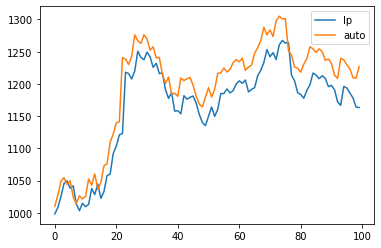

In [126]:
which_stock = ranking[0]

# now decoded last price plot
stock_autoencoder = copy.deepcopy(predict[:, which_stock]);stock_autoencoder

stock_autoencoder = stock_autoencoder.cumsum()


stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
plt.plot(np.array(stock['calibrate']['lp'].iloc[:, which_stock]),label = 'lp')
plt.plot(stock_autoencoder,label = 'auto')
plt.legend()


In [100]:
autoencoder.save('D:/jupyter/Deep-Portfolio-Theory/model/test.h5')

### Let see what the worst one looks like 

##### The communal information is the most shared information that was saved during dimension reduction.
##### Thus, the faliure of reproducing the path means the every other stocks in the market doest share too much common information with this stock

##### in other words, this stock doesnt follows others and when market goes down, it maynot. we need these kind of stocks to hedge our portfolio

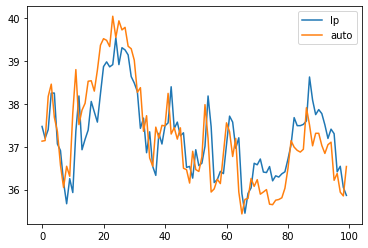

In [155]:
which_stock = ranking[-1]

# now decoded last price plot
stock_autoencoder = copy.deepcopy(predict[:, which_stock]);stock_autoencoder

stock_autoencoder = stock_autoencoder.cumsum()

stock_autoencoder

stock['calibrate']['net'].iloc[:,which_stock]

stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
plt.plot(np.array(stock['calibrate']['lp'].iloc[:, which_stock]),label = 'lp')
plt.plot(stock_autoencoder,label = 'auto')
plt.legend()

### Pick 50(or 20 or 10 or ...) from this ranking list
##### we want both market follower and no-market follower

### Calibriation

In [164]:
spy_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)
non = np.array([15, 35, 55]) # numbrt of non_communal
initial = 50 # number of market follower

# test different number of non_communal
for non_communal in non:  
    encoding_dim = 128
    s = initial + non_communal # dimension of inputs, number of stocks
    stock_index = np.concatenate((ranking[0:initial], ranking[-non_communal:])) # set the index of portoflio
    
    
    # connect layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    encoded = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(encoded)
    encoded = Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.01))(encoded)
    decoded = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(encoded)
    decoded = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(decoded)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(decoded) 
    
    
    # construct and compile
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = spy['calibrate']['percentage']
    # normalize the data ( clean)
    dl_scaler[s] = StandardScaler()     
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10 , verbose = 0)    # fit the model
    deep_learner.save('D:/jupyter/Deep-Portfolio-Theory/model/trained_autoencoder{}.h5'.format(s))
    
    #calculate the error
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    
    relative_percentage = (relative_percentage/100 ) + 1
    
    spy_predict['calibrate'][s] = spy['calibrate']['lp'].iloc[0,0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm(np.array(spy_predict['calibrate'][s]) - np.array(spy['calibrate']['lp']))

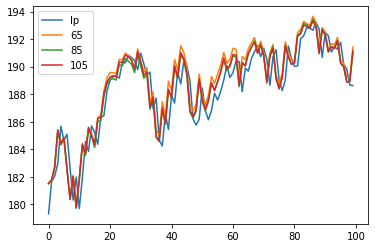

In [165]:
# plot results 
plt.plot(np.array(spy['calibrate']['lp'] ), label = 'lp')

for s in (initial + non):
   
    plt.plot(np.array(spy_predict['calibrate'][s] ), label = '{}'.format(s))
plt.legend()

In [166]:
print(total_2_norm_diff['calibrate'])

defaultdict(None, {65: 447.89978, 85: 441.88712, 105: 440.31323})


### validating

In [167]:
for non_communal in non:  
    s = initial + non_communal
    stock_index = np.concatenate((ranking[0:initial], ranking[-non_communal:])) # portfolio index
    
    # load  trained models
    deep_learner = load_model('D:/jupyter/Deep-Portfolio-Theory/model/trained_autoencoder{}.h5'.format(s))
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # calculate the error
    relative_percentage = copy.deepcopy(deep_learner.predict(x))

    relative_percentage = (relative_percentage /100) + 1
    
    spy_predict['validate'][s] = spy['validate']['lp'].iloc[0,0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((np.array(spy_predict['validate'][s]) - np.array(spy['validate']['lp'])))

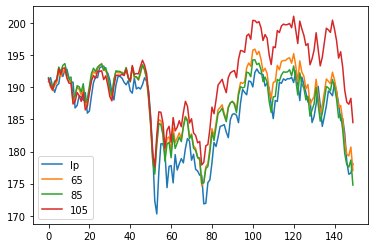

In [168]:
# plot result
plt.plot(np.array(spy['validate']['lp'] ), label = 'lp')

for s in (initial + non): 
    plt.plot(np.array(spy_predict['validate'][s] ), label = '{}'.format(s))
plt.legend()

### few test

In [172]:
error = []
for non_communal in range(5, 79, 1):  
    encoding_dim = 128
    s = initial + non_communal
    stock_index = np.concatenate((ranking[0:initial], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    encoded = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(encoded)
    encoded = Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.01))(encoded)
    decoded = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(encoded)
    decoded = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(decoded)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = spy['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10 , verbose = 0)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = spy['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = spy['validate']['lp'].iloc[0,0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((np.array(predict_curve) - np.array(spy['validate']['lp']))))    

Text(0, 0.5, 'number of stocks in the portfolio')

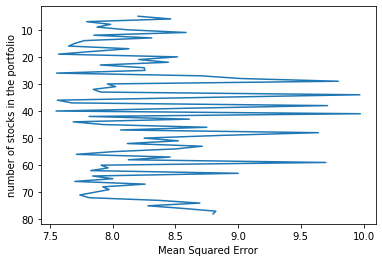

In [173]:
mse = [e/len(spy['validate']['lp']) for e in error] # mse\
plt.gca().invert_yaxis()
plt.plot(mse, list(range(5,79,1)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 

In [ ]:
### Part 2 : beat market

### 在改成class 不用看

In [ ]:
class autoencoder:
    def __init__(self,data , model = 'Nan', optimizer = 'adam', loss = 'mean_squared_error'):
        self.data = data
        self.optimizer = optimizer
        self.loss = loss
        if model == 'NaN':
            self.construct_model()
            
    def construct_model(self):
        encoding_dim = 50
        dim = test.shape[1]


        input_stock = Input(shape=(dim,))

        encoded = Dense(encoding_dim, activation='relu')(input_stock)

        decoded = Dense(dim, activation='linear')(encoded)


        self.autoencoder = Model(input_stock, decoded)
        self.autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        
    def train(self):
        self.autoencoder.fit(test, test, shuffle=False, epochs=200, batch_size = 10 , verbose = False) 
        
    def predict (self , obj):
        res = self.autoencoder.predict(obj)
        return res